In [2]:
import pandas as pd
import numpy as np
import uproot
import awkward as ak
from tqdm import tqdm
import os
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar


In [3]:
def cfd_waveform(wave, delay, attenuation):
    wave_delayed = np.pad(wave, (delay, 0))[:len(wave)]
    wave_attenuated = wave * attenuation
    cfd_wave = -wave_attenuated + wave_delayed
    return cfd_wave

def read_detector_data(file_path):
    print(f"Reading file: {file_path}")
    events = []
    current_event = None
    values = []

    # Count total lines for progress bar
    with open(file_path, 'r') as file:
        total_lines = sum(1 for _ in file)
        file.seek(0)  # Reset file pointer to beginning

        with tqdm(total=total_lines, desc=f"Reading {file_path}", unit="lines") as pbar:
            for line in file:
                pbar.update(1)
                line = line.strip()
                if not line:
                    continue
                if line.startswith('Record Length:'):
                    if current_event:
                        current_event['values'] = np.array(values)
                        events.append(current_event)
                    current_event = {'Record Length': int(line.split(':')[1])}
                    values = []
                elif line.startswith('Event Number:'):
                    current_event['Event Number'] = int(line.split(':')[1])
                elif line.startswith('Trigger Time Stamp:'):
                    current_event['Trigger Time Stamp'] = int(line.split(':')[1])
                elif line[0].isdigit():
                    values.append(float(line))

    # Add the last event
    if current_event:
        current_event['values'] = np.array(values)
        events.append(current_event)

    # Create DataFrame
    df = pd.DataFrame(events)
    print(f"Finished reading {len(df)} events from {file_path}")
    return df



def process_detector_data(df, channel):
    print(f"Processing data for channel {channel}")
    threshold = 0.5  # 50% of max value

    df['bg'] = df['values'].apply(lambda x: x[:40].mean())
    df['values'] = df['values'].apply(lambda x: x - np.mean(x[:40]))
    df['max'] = df['values'].apply(lambda x: x.max())
    df['max_index'] = df['values'].apply(lambda x: x.argmax())



    #leading edge threshold crossing
    df['leading_edge'] = df['values'].apply(lambda x: np.argmax(x > x.max() * threshold))

    # CFD method
    delay = 10
    attenuation = 0.5
    df['cfd'] = df['values'].apply(lambda x: cfd_waveform(x, delay, attenuation))

    # Calculate CFD zero crossing
    print("Calculating CFD zero crossings...")

   

    if channel != 99:
        #df['integral'] = df['values'].apply(lambda x: x[x > 0].sum())
        df['integral'] = df['values'].apply(lambda x: np.trapz(x[x > 0]))
        df['trailing_edge'] = df['values'].apply(lambda x: len(x) - 1 - np.argmax(x[::-1] > x.max() * threshold))
        df['tot'] = df['trailing_edge'] - df['leading_edge']
        # Add blank time diff column for this channel
        df['time_diff'] = 0




    df.drop(columns=['bg', 'Record Length'], inplace=True)
    #df.drop(columns=['values'], inplace=True) #uncomment to remove waveform data
    df.columns = [str(channel) + '_' + col if col not in ['Event Number', 'Trigger Time Stamp'] else col for col in df.columns]
    print(f"Finished processing data for channel {channel}")
    return df


In [4]:
base_path = '/home/agcheyne/Code/EIC/MCPtest/data/set2/27'

# Waveform data
channels = [99, 0, 1]  # List of channels

dfs = []  # List to store DataFrames for each channel

for channel in channels:
    if channel == 99:
        filename = f'TR_0_0.txt'
    else:
        filename = f'wave_{channel}.txt'
    df = read_detector_data(f'{base_path}/{filename}')
    df = process_detector_data(df, channel)
    dfs.append(df)  # Add processed DataFrame to the list

# Merge all channel DataFrames
merged_df = pd.concat(dfs, axis=1)

print(merged_df.head())

#remove duplicate columns
merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
print(merged_df.head())

#sort alphabetically
merged_df = merged_df.reindex(sorted(merged_df.columns), axis=1)
print(merged_df.head())

# update time_diff column
for channel in channels:
    if channel != 99:
        merged_df[str(channel) + '_time_diff'] = merged_df[str(channel) + '_leading_edge'] - merged_df['99_leading_edge']

print(merged_df.head())



Reading file: /home/agcheyne/Code/EIC/MCPtest/data/set2/27/TR_0_0.txt


Reading /home/agcheyne/Code/EIC/MCPtest/data/set2/27/TR_0_0.txt: 100%|██████████| 43284969/43284969 [00:22<00:00, 1930835.63lines/s]


Finished reading 41943 events from /home/agcheyne/Code/EIC/MCPtest/data/set2/27/TR_0_0.txt
Processing data for channel 99
Calculating CFD zero crossings...
Finished processing data for channel 99
Reading file: /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_0.txt


Reading /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_0.txt: 100%|██████████| 43285135/43285135 [00:22<00:00, 1947106.74lines/s]


Finished reading 41943 events from /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_0.txt
Processing data for channel 0
Calculating CFD zero crossings...
Finished processing data for channel 0
Reading file: /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_1.txt


Reading /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_1.txt: 100%|██████████| 43285130/43285130 [00:21<00:00, 1972892.55lines/s]


Finished reading 41943 events from /home/agcheyne/Code/EIC/MCPtest/data/set2/27/wave_1.txt
Processing data for channel 1
Calculating CFD zero crossings...
Finished processing data for channel 1
   Event Number  Trigger Time Stamp  \
0             0                2758   
1             1              119945   
2             2              237133   
3             3              354320   
4             4              471508   

                                           99_values       99_max  \
0  [12.90867575, 12.860442750000004, 1.8269727499...  4037.002914   
1  [-1.3170217500000092, -1.3170217500000092, 6.6...  4085.517451   
2  [0.3453377499999988, 0.3453377499999988, -1.63...  4049.398561   
3  [3.9768382750000058, 3.9768382750000058, -8.95...  4014.482453   
4  [-10.042513999999997, -10.033636999999999, -7....  4022.661832   

   99_max_index  99_leading_edge  \
0            79               72   
1            98               92   
2            78               71   
3           

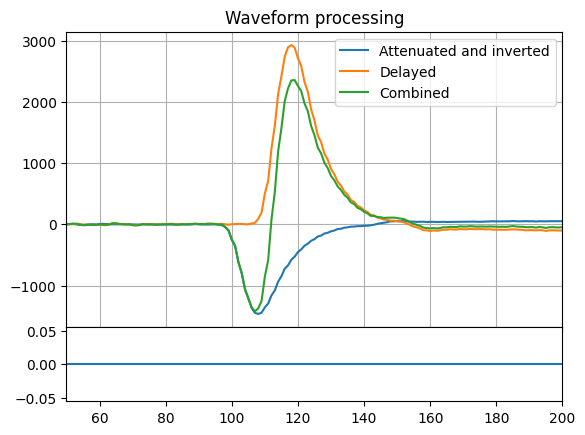

In [5]:
import matplotlib.pyplot as plt

#split canvas vertical for residuals
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0}, height_ratios=[4, 1])
#setting lower to smaller


#set xlim
ax1.set_xlim(50, 200)

delay = 10
attenuation = 0.5

# Plot adjusted waveforms
wave = merged_df['0_values'][2]

wave_attenuated = wave * -attenuation
wave_delayed = np.pad(wave, (delay, 0))[:len(wave)]
wave_cfd = wave_attenuated + wave_delayed

ax1.plot(wave_attenuated, label='Attenuated and inverted')
ax1.plot(wave_delayed, label='Delayed')
ax1.plot(wave_cfd, label='Combined')
ax1.legend()
ax1.grid()
ax1.set_title('Waveform processing')


# Plot time difference
difference = merged_df['0_cfd'][2] - wave_cfd
ax2.plot(difference, label='difference between dataframe and above')


plt.show()

# #plot result
# plt.plot(cfd_wave = -wave_attenuated + wave_delayed)
# plt.plot(merged_df['0_cfd'][2])
# plt.grid()
# plt.


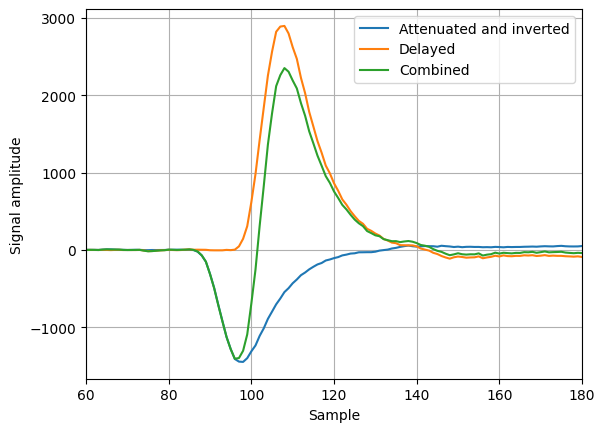

In [6]:

#set xlim


delay = 10
attenuation = 0.5

# Plot adjusted waveforms
wave = merged_df['0_values'][40]

wave_attenuated = wave * -attenuation
wave_delayed = np.pad(wave, (delay, 0))[:len(wave)]
wave_cfd = wave_attenuated + wave_delayed

plt.plot(wave_attenuated, label='Attenuated and inverted')
plt.plot(wave_delayed, label='Delayed')
plt.plot(wave_cfd, label='Combined')
plt.legend()
plt.grid()
plt.xlim(60, 180)
plt.xlabel('Sample')
plt.ylabel('Signal amplitude')



plt.show()


In [7]:
merged_df['Trigger Time Stamp']

#subtract trigger time stamp from previous event time stamp to get time between events
times = []
for i in range(1, len(merged_df)):
    times.append(merged_df['Trigger Time Stamp'][i] - merged_df['Trigger Time Stamp'][i-1])

times = np.array(times)

In [8]:
def robust_zero_crossing(cfd_signal, threshold=0.1, window_start=None, window_end=None):
   
    # Apply threshold to only consider zero-crossings where the signal magnitude either side of the crossing is significant.    
    valid_crossings = np.where((np.abs(cfd_signal[:-1]) > threshold) &  #   Rising edge of the signal is above threshold
                               (np.abs(cfd_signal[1:]) > threshold) & #     Falling edge
                               (cfd_signal[:-1] * cfd_signal[1:] < 0))[0] # Zero crossing then occurs between the two points
    
    # Apply window if specified - can select the minimum and maximum index of the cfd function to do this

    window_end = np.argmax(cfd_signal)
    window_start = np.argmin(cfd_signal)

    if window_start is not None and window_end is not None:
        valid_crossings = valid_crossings[(valid_crossings >= window_start) & (valid_crossings < window_end)]
    

    if len(valid_crossings) == 0:
        print(f'No valid crossings found in the specified window for event')
        return None


    # Choose the crossing with the steepest slope
    slopes = np.abs(cfd_signal[valid_crossings+1] - cfd_signal[valid_crossings])

    # Find the index of the zero crossing with the steepest slope
    zero_crossing = valid_crossings[np.argmax(slopes)]

    return zero_crossing


zeros = []
for i in range(0, len(merged_df)):
    zeros.append(robust_zero_crossing(merged_df['0_cfd'][i], threshold=.01))

zeros = np.array(zeros)

merged_df['0_zero_crossing'] = zeros

zeros = []
for i in range(0, len(merged_df)):
    zeros.append(robust_zero_crossing(merged_df['1_cfd'][i], threshold=.01))

zeros = np.array(zeros)

merged_df['1_zero_crossing'] = zeros


zeros = []
for i in range(0, len(merged_df)):
    zeros.append(robust_zero_crossing(merged_df['99_cfd'][i], threshold=.01))

zeros = np.array(zeros)

merged_df['99_zero_crossing'] = zeros

merged_df['0_CDFtime_diff'] = merged_df['0_zero_crossing'] - merged_df['99_zero_crossing']

No valid crossings found in the specified window for event


Min time diff: 30, Max time diff: 32


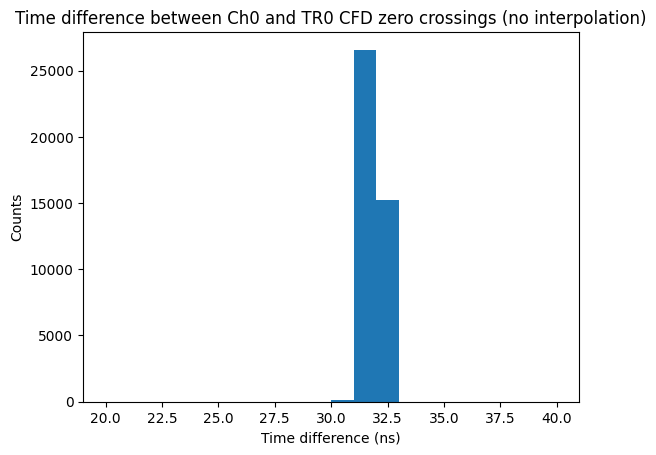

In [9]:
min_time_diff = np.min(merged_df['0_CDFtime_diff'])
max_time_diff = np.max(merged_df['0_CDFtime_diff'])
print(f'Min time diff: {min_time_diff}, Max time diff: {max_time_diff}')
plt.hist(merged_df['0_CDFtime_diff'], bins=20, range=(20, 40))
plt.xlabel('Time difference (ns)')
plt.ylabel('Counts')
plt.title('Time difference between Ch0 and TR0 CFD zero crossings (no interpolation)')
plt.show()


In [10]:
dfplay = merged_df.copy()

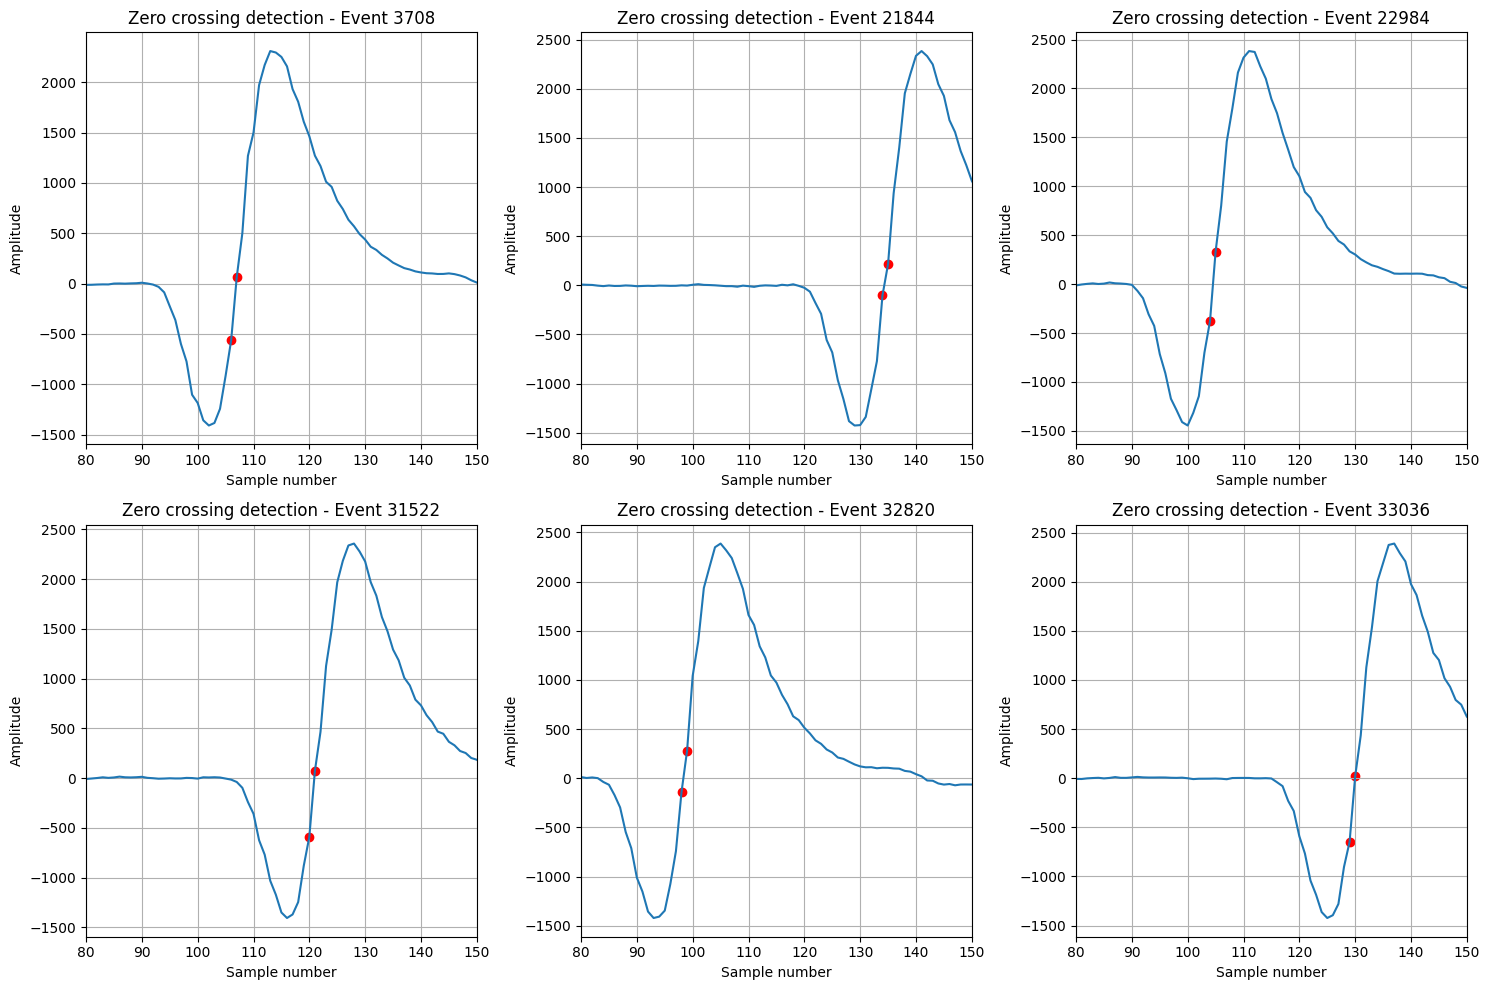

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Generate 6 random event indices
events = np.random.choice(len(dfplay), size=6, replace=False)
events.sort()

for i, event in enumerate(events):
    values = dfplay['0_cfd'][event]

    window_start = np.argmin(values)
    window_end = np.argmax(values)

    zero_cross = np.where(np.diff(np.sign(values[window_start:window_end])))[0] + window_start

    # Plot on the corresponding subplot
    axs[i].plot(values)
    axs[i].scatter(zero_cross, values[zero_cross], color='red')
    axs[i].scatter(zero_cross+1, values[zero_cross+1], color='red')

    axs[i].grid(True)
    axs[i].set_xlim(80, 150)
    axs[i].set_xlabel('Sample number')
    axs[i].set_ylabel('Amplitude')
    axs[i].set_title(f'Zero crossing detection - Event {event}')

# Adjust layout and display
plt.tight_layout()
plt.show()

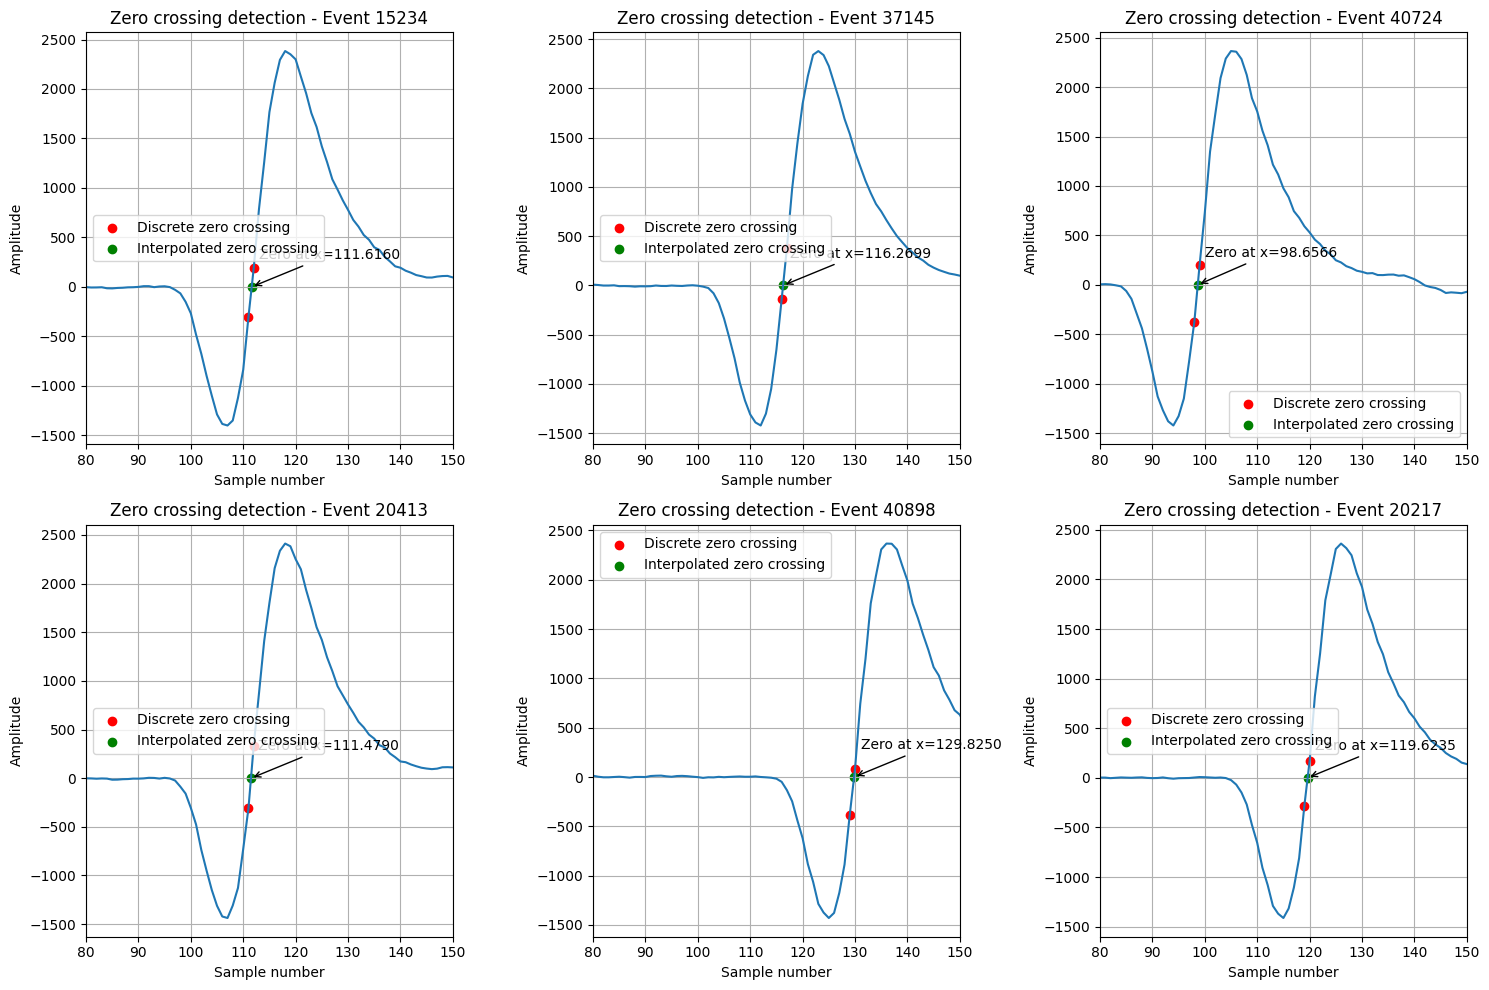

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

# Generate 6 random event indices
events = np.random.choice(len(dfplay), size=6, replace=False)

for i, event in enumerate(events):
    values = dfplay['0_cfd'][event]

    window_start = np.argmin(values)
    window_end = np.argmax(values)

    zero_cross = np.where(np.diff(np.sign(values[window_start:window_end])))[0] + window_start

    # Interpolation and root finding
    start = int(zero_cross[0] - 2)
    end = int(zero_cross[0] + 3)
    
    x = np.arange(start, end)
    y = values[start:end]
    f = interp1d(x, y, kind='linear')

    def find_y(x):
        return f(x)

    try:
        result = root_scalar(find_y, bracket=[start, end-1], method='brentq') # Find the zero crossing using the interpolated function 
        
        if result.converged:
            x_zero = result.root
            y_zero = f(x_zero)
            
            # Plot on the corresponding subplot
            axs[i].plot(values)
            axs[i].scatter(zero_cross, values[zero_cross], color='red', label='Discrete zero crossing')
            axs[i].scatter(zero_cross+1, values[zero_cross+1], color='red')

            axs[i].scatter(x_zero, y_zero, color='green', label='Interpolated zero crossing')
            
            axs[i].grid(True)
            axs[i].set_xlim(80, 150)
            axs[i].set_xlabel('Sample number')
            axs[i].set_ylabel('Amplitude')
            axs[i].set_title(f'Zero crossing detection - Event {event}')
            axs[i].legend()
            
            # Add text annotation for interpolated zero crossing
            axs[i].annotate(f'Zero at x={x_zero:.4f}', 
                            xy=(x_zero, y_zero), 
                            xytext=(5, 20), 
                            textcoords='offset points',
                            arrowprops=dict(arrowstyle="->"))
        else:
            axs[i].text(0.5, 0.5, "Failed to find zero crossing", 
                        ha='center', va='center', transform=axs[i].transAxes)
    except ValueError:
        axs[i].text(0.5, 0.5, "Error in zero crossing calculation", 
                    ha='center', va='center', transform=axs[i].transAxes)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [13]:
def find_cfd_zero(cfd_wave):
    count = 0

    # Find the window where the zero crossing occurs by finding the minimum and maximum of the CFD function
    window_start = np.argmin(cfd_wave)
    window_end = np.argmax(cfd_wave)
    
    # Find the zero crossing by looking for a sign change in the CFD function - output is the index of the zero crossing (closest to the start of the window)
    zero_cross = np.where(np.diff(np.sign(cfd_wave[window_start:window_end])))[0] + window_start  
    
    if len(zero_cross) == 0:
        return np.nan
    
    # Define a window around the zero crossing
    start = int(zero_cross[0] - 2) 
    end = int(zero_cross[0] + 3) 
    
    # Interpolate the CFD function to find the zero crossing more accurately
    x = np.arange(start, end) # Sample numbers to be interpolated
    y = cfd_wave[start:end] # Values to be interpolated

    # Interpolate the CFD function using a cubic spline
    f = interp1d(x, y, kind='cubic')

    # Define a function that returns the y-value for a given x
    def find_y(x):
        return f(x)
    
    # Use root_scalar to find where y = 0
    result = root_scalar(find_y, bracket=[start, end-1], method='brentq') 

    if result.converged:
        x_zero = result.root
        return x_zero
    else:
        print("Failed to find an exact zero crossing")
        count += 1
        return np.nan
zeros = []
for i in range(0, len(dfplay)):
    zeros.append(find_cfd_zero(dfplay['0_cfd'][i]))

zeros = np.array(zeros)

dfplay['0_zero_crossing'] = zeros


99.45964011666679


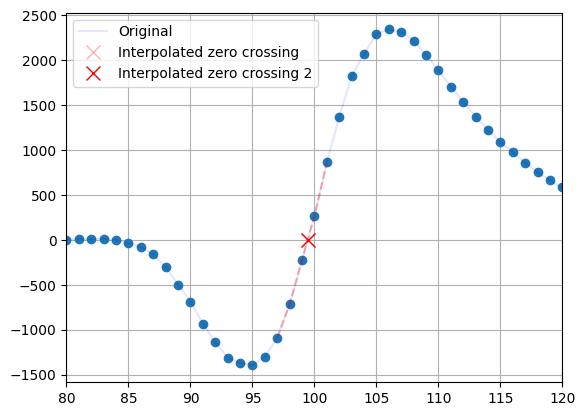

In [14]:
example_cfd = dfplay['0_cfd'][552]

plt.plot(example_cfd , 'o')
plt.plot(example_cfd ,  label='Original', color='blue', alpha=0.1)
plt.plot
plt.grid()
plt.xlim(80, 120)

window_start = np.argmin(example_cfd)
window_end = np.argmax(example_cfd)

# Find the zero crossing by looking for a sign change in the CFD function - output is the index of the zero crossing (closest to the start of the window)
zero_cross = np.where(np.diff(np.sign(example_cfd [window_start:window_end])))[0] + window_start  

# Define a window around the zero crossing
    # Define a window around the zero crossing
start = int(zero_cross[0] - 2) 
end = int(zero_cross[0] + 3) 

# Interpolate the CFD function to find the zero crossing more accurately
x = np.arange(start, end) # Sample numbers to be interpolated
y = example_cfd[start:end] # Values to be interpolated

# Interpolate the CFD function using a cubic spline
f = interp1d(x, y, kind='linear')

# Define a function that returns the y-value for a given x
def find_y(x):
    return f(x)

# Use root_scalar to find where y = 0
result = root_scalar(find_y, bracket=[start, end-1], method='brentq') 

x_fine = np.linspace(start, end-1, 1000)
y_fine = f(x_fine)

#find zero crossing
zero_cross_fine = np.where(np.diff(np.sign(y_fine)))[0]
# Linear interpolation to find the precise zero crossing
x0, y0 = x_fine[zero_cross_fine[0]], y_fine[zero_cross_fine[0]]
x1, y1 = x_fine[zero_cross_fine[0] + 1], y_fine[zero_cross_fine[0] + 1]

zero = x0 - y0 * (x1 - x0) / (y1 - y0)

print(zero)
plt.plot(zero, 0, 'x', color='red', label='Interpolated zero crossing', markersize=10, alpha = 0.3)

plt.plot(x_fine, find_y(x_fine),'--' , color='red', alpha = 0.3)

if result.converged:
    x_zero = result.root
    y_zero = f(x_zero)
    plt.plot(x_zero, y_zero, 'x' ,color='red', label='Interpolated zero crossing 2', markersize=10)
    plt.legend()
    plt.show()




Text(0.5, 1.0, 'TR0 max index')

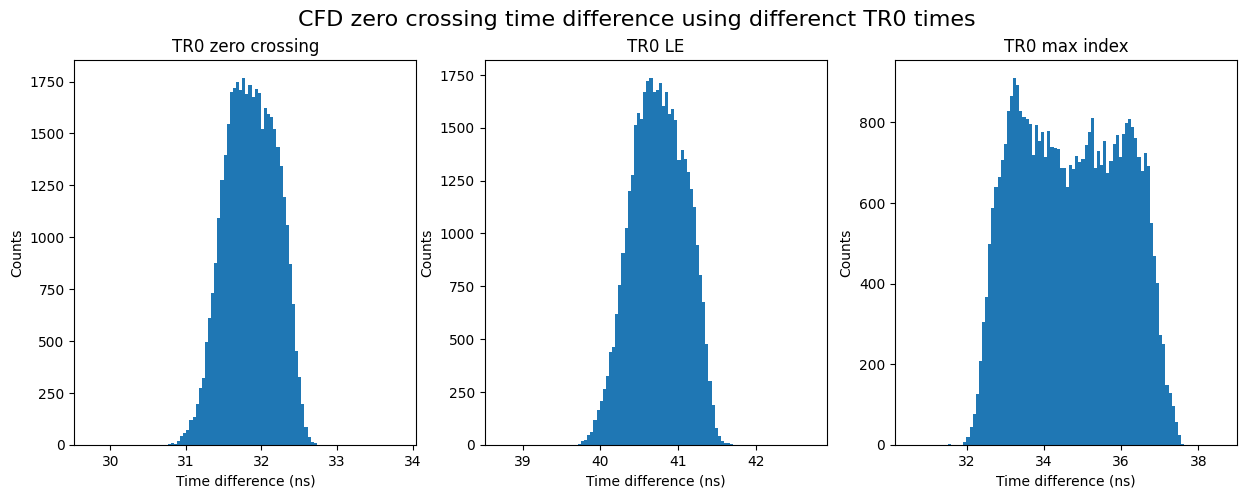

In [15]:
#make 3 subfigures
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('CFD zero crossing time difference using differenct TR0 times', fontsize=16)

for i in range(3):
    axs[i].set_xlabel('Time difference (ns)')
    axs[i].set_ylabel('Counts')

#plot - trigger zero crossing
min_time_diff = np.min(dfplay['0_zero_crossing'] - dfplay['99_zero_crossing'])
max_time_diff = np.max(dfplay['0_zero_crossing'] - dfplay['99_zero_crossing'])
axs[0].hist(dfplay['0_zero_crossing'] - dfplay['99_zero_crossing'], bins=100, range=(min_time_diff-1, max_time_diff+1))
axs[0].set_title('TR0 zero crossing')

#plot - trigger LE
#find min and max
min_time_diff = np.min(dfplay['0_zero_crossing'] - dfplay['99_leading_edge'])
max_time_diff = np.max(dfplay['0_zero_crossing'] - dfplay['99_leading_edge'])
axs[1].hist(dfplay['0_zero_crossing'] - dfplay['99_leading_edge'], bins=100, range=(min_time_diff-1, max_time_diff+1))
axs[1].set_title('TR0 LE')


#plot - trigger max location
min_time_diff = np.min(dfplay['0_zero_crossing'] - dfplay['99_max_index'])
max_time_diff = np.max(dfplay['0_zero_crossing'] - dfplay['99_max_index'])
axs[2].hist(dfplay['0_zero_crossing'] - dfplay['99_max_index'], bins=100, range=(min_time_diff-1, max_time_diff+1))
axs[2].set_title('TR0 max index')



In [16]:
#see how many NaN in the zero crossing
print(f"Number of NaN in zero crossing: {dfplay['0_zero_crossing'].isna().sum()}")

Number of NaN in zero crossing: 0


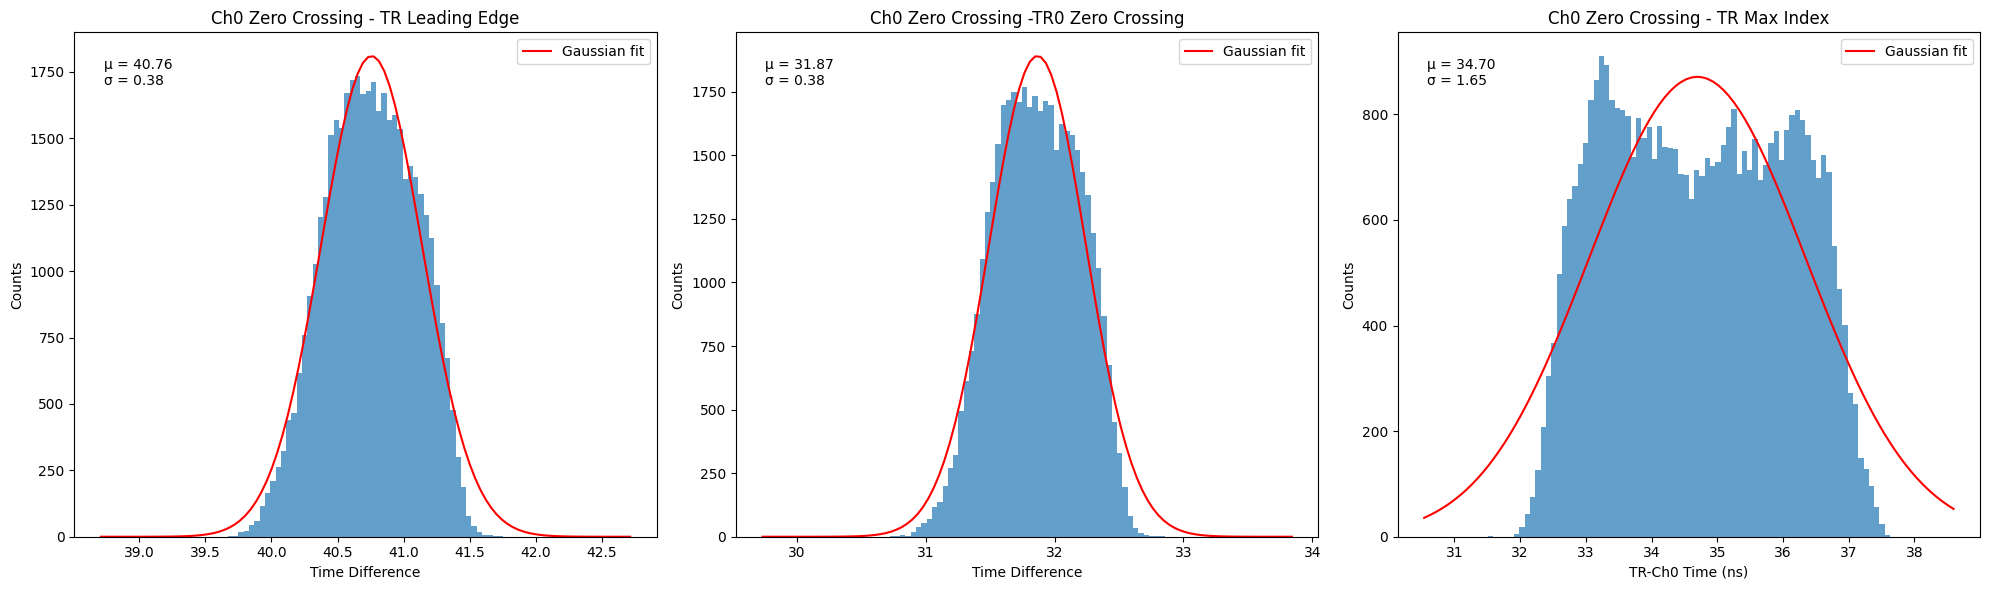

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Function to fit Gaussian and plot
def fit_and_plot_gaussian(ax, data, bins, range):
    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Fit Gaussian
    popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[counts.max(), np.mean(data), np.std(data)])
    
    # Plot histogram and fit
    ax.hist(data, bins=bins, range=range, alpha=0.7)
    x_fit = np.linspace(range[0], range[1], 100)
    ax.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian fit')

    
    # Add fit parameters to plot
    ax.text(0.05, 0.95, f'μ = {popt[1]:.2f}\nσ = {popt[2]:.2f}', 
            transform=ax.transAxes, verticalalignment='top')    
    ax.legend()

# Create 3 subfigures
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot - trigger LE
data = dfplay['0_zero_crossing'] - dfplay['99_leading_edge']
min_time_diff, max_time_diff = np.min(data), np.max(data)
fit_and_plot_gaussian(axs[0], data, bins=100, range=(min_time_diff-1, max_time_diff+1))
axs[0].set_title('Ch0 Zero Crossing - TR Leading Edge')
axs[0].set_xlabel('Time Difference')
axs[0].set_ylabel('Counts')

# Plot - trigger zero crossing
data = dfplay['0_zero_crossing'] - dfplay['99_zero_crossing']
min_time_diff, max_time_diff = np.min(data), np.max(data)
fit_and_plot_gaussian(axs[1], data, bins=100, range=(min_time_diff-1, max_time_diff+1))
axs[1].set_title('Ch0 Zero Crossing -TR0 Zero Crossing')
axs[1].set_xlabel('Time Difference')
axs[1].set_ylabel('Counts')

# Plot - trigger max location
data = dfplay['0_zero_crossing'] - dfplay['99_max_index']
min_time_diff, max_time_diff = np.min(data), np.max(data)
fit_and_plot_gaussian(axs[2], data, bins=100, range=(min_time_diff-1, max_time_diff+1))
axs[2].set_title('Ch0 Zero Crossing - TR Max Index')
axs[2].set_xlabel('TR-Ch0 Time (ns)')
axs[2].set_ylabel('Counts')

plt.tight_layout()
plt.show()

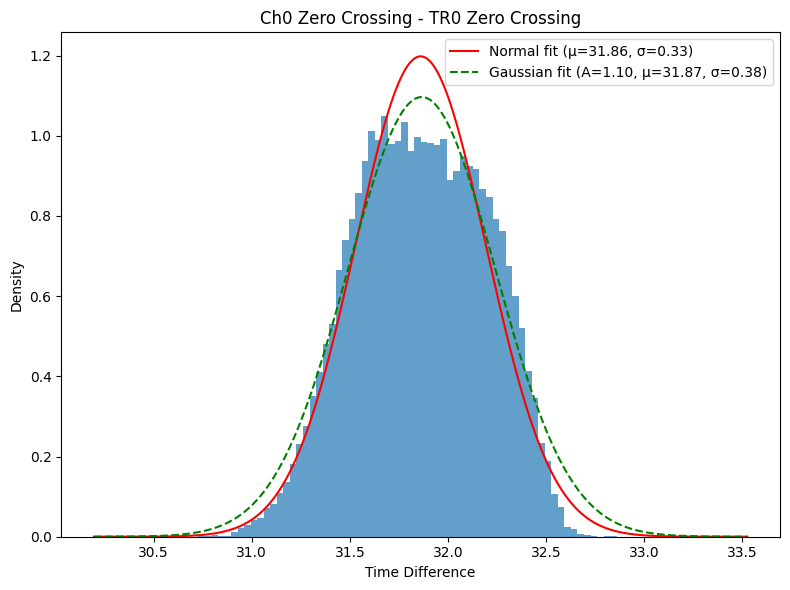

Normal fit parameters: μ = 31.8609, σ = 0.3330
Gaussian fit parameters: A = 1.0966, μ = 31.8662, σ = 0.3768


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def normal_distribution(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Fit a normal
def fit_normal(data):
    mu = np.mean(data)
    sigma = np.std(data)
    return mu, sigma

# Plot - trigger zero crossing
data = dfplay['0_zero_crossing'] - dfplay['99_zero_crossing']
mu, sigma = fit_normal(data)

# Create a figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram
counts, bins, _ = ax.hist(data, bins=100, range=(mu-5*sigma, mu+5*sigma), alpha=0.7, density=True)

# Generate points for the fitted curves
x_fit = np.linspace(mu-5*sigma, mu+5*sigma, 1000)
y_fit_normal = normal_distribution(x_fit, mu, sigma)

# Fit Gaussian
bin_centers = (bins[:-1] + bins[1:]) / 2
popt, _ = curve_fit(gaussian, bin_centers, counts, p0=[np.max(counts), mu, sigma])
y_fit_gaussian = gaussian(x_fit, *popt)

# Plot the fitted curves
ax.plot(x_fit, y_fit_normal, 'r-', label=f'Normal fit (μ={mu:.2f}, σ={sigma:.2f})')
ax.plot(x_fit, y_fit_gaussian, 'g--', label=f'Gaussian fit (A={popt[0]:.2f}, μ={popt[1]:.2f}, σ={popt[2]:.2f})')

ax.set_xlabel('Time Difference')
ax.set_ylabel('Density')
ax.set_title('Ch0 Zero Crossing - TR0 Zero Crossing')
ax.legend()

plt.tight_layout()
plt.show()

print(f"Normal fit parameters: μ = {mu:.4f}, σ = {sigma:.4f}")
print(f"Gaussian fit parameters: A = {popt[0]:.4f}, μ = {popt[1]:.4f}, σ = {popt[2]:.4f}")

In [19]:
#print the df columns
dfplay.sort_index(axis=1, inplace=True)
dfplay['0_CDFtime_diff'] = dfplay['0_zero_crossing'] - dfplay['99_zero_crossing']
dfplay['0_CDFtime_diff']
dfplay


,0_CDFtime_diff,0_cfd,0_integral,0_leading_edge,0_max,0_max_index,0_time_diff,0_tot,0_trailing_edge,0_values,...,1_values,1_zero_crossing,99_cfd,99_leading_edge,99_max,99_max_index,99_values,99_zero_crossing,Event Number,Trigger Time Stamp
0,31.885592,"[-2.375152949999972, -2.381729449999966, -3.86...",44906.810714,104,2876.762513,109,32,13,117,"[4.750305899999944, 4.763458899999932, 7.73214...",...,"[-4.989396650000003, -4.980637650000006, -2.97...",112,"[-6.454337875, -6.430221375000002, -0.91348637...",72,4037.002914,79,"[12.90867575, 12.860442750000004, 1.8269727499...",81,0,2758
1,31.855878,"[2.2350193000000047, 2.2350193000000047, 0.747...",45025.235905,124,2907.152520,129,32,12,136,"[-4.470038600000009, -4.470038600000009, -1.49...",...,"[-2.267332524999972, -2.267332524999972, 1.699...",133,"[0.6585108750000046, 0.6585108750000046, -3.30...",92,4085.517451,98,"[-1.3170217500000092, -1.3170217500000092, 6.6...",101,1,119945
2,31.886953,"[1.427807987499989, 1.427807987499989, -3.0224...",45754.441654,103,2927.035253,108,32,12,115,"[-2.855615974999978, -2.855615974999978, 6.044...",...,"[1.055872249999993, 1.055872249999993, -0.9220...",111,"[-0.1726688749999994, -0.1726688749999994, 0.8...",71,4049.398561,78,"[0.3453377499999988, 0.3453377499999988, -1.63...",80,2,237133
3,32.258580,"[2.538677012500017, 2.538677012500017, 1.54374...",46045.363209,127,2952.510292,132,32,13,140,"[-5.077354025000034, -5.077354025000034, -3.08...",...,"[-2.530447424999977, -2.530447424999977, 1.449...",136,"[-1.9884191375000029, -1.9884191375000029, 4.4...",95,4014.482453,100,"[3.9768382750000058, 3.9768382750000058, -8.95...",104,3,354320
4,32.353856,"[-1.344699862500022, -1.349140362500009, -2.80...",46213.018631,109,2989.037300,114,32,13,122,"[2.689399725000044, 2.698280725000018, 5.61759...",...,"[2.639197549999949, 2.642157549999922, 3.58045...",118,"[5.0212569999999985, 5.016818499999999, 3.5179...",77,4022.661832,86,"[-10.042513999999997, -10.033636999999999, -7....",86,4,471508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41938,32.362540,"[2.4310425124999995, 2.448300012499999, 4.3207...",45470.743406,103,2948.279272,108,31,13,116,"[-4.862085024999999, -4.896600024999998, -8.64...",...,"[-4.69259492499998, -4.6753219249999916, -2.60...",112,"[-0.952533774999992, -0.9223252749999915, 2.47...",72,4016.280312,78,"[1.905067549999984, 1.844650549999983, -4.9592...",80,41938,934028650
41939,32.077013,"[-1.2984371499999838, -1.2981931499999746, -0....",45658.427708,122,2923.739452,127,32,13,135,"[2.5968742999999677, 2.596386299999949, 1.5931...",...,"[6.1795432999999775, 6.1785972999999785, 4.169...",131,"[-4.639301824999997, -4.638355824999998, -2.63...",90,4053.583780,96,"[9.278603649999994, 9.276711649999996, 5.27860...",99,41939,934145837
41940,31.257129,"[-0.45229987499999424, -0.45229987499999424, 2...",44899.330905,103,2893.887022,108,32,12,115,"[0.9045997499999885, 0.9045997499999885, -5.04...",...,"[-2.390247274999979, -2.390247274999979, -1.39...",111,"[0.20342044999999587, 0.20342044999999587, -0....",71,4068.528706,75,"[-0.40684089999999173, -0.40684089999999173, 0...",80,41940,934263025
41941,31.990581,"[1.5431392375000144, 1.5431392375000144, 2.525...",46086.741922,125,2972.656642,130,32,13,138,"[-3.0862784750000287, -3.0862784750000287, -5....",...,"[-7.875243399999988, -7.875243399999988, -1.98...",134,"[4.673695475000002, 4.673695475000002, -1.7110...",93,4114.721945,101,"[-9.347390950000005, -9.347390950000005, 3.422...",102,41941,934380212


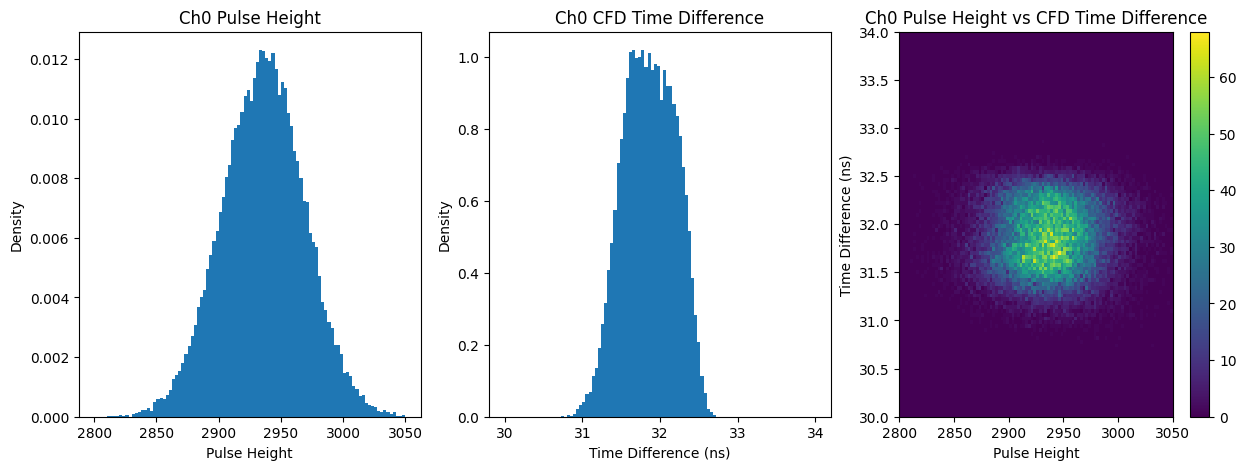

In [25]:
#3 Hists

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#Pulse height spectra
axs[0].hist(dfplay['0_max'], bins=100, range=(2800, 3050), density=True)
axs[0].set_title('Ch0 Pulse Height')
axs[0].set_xlabel('Pulse Height')
axs[0].set_ylabel('Density')

#TDC Spectra
axs[1].hist(dfplay['0_CDFtime_diff'], bins=100, range=(30, 34), density=True)
axs[1].set_title('Ch0 CFD Time Difference')
axs[1].set_xlabel('Time Difference (ns)')
axs[1].set_ylabel('Density')

#2D of pulse height vs TDC
h2d = plt.hist2d(dfplay['0_max'], dfplay['0_CDFtime_diff'], bins=(100, 100), range=[[2800, 3050], [30, 34]], cmap='viridis')
axs[2].set_title('Ch0 Pulse Height vs CFD Time Difference')
axs[2].set_xlabel('Pulse Height')
axs[2].set_ylabel('Time Difference (ns)')
h2d = plt.colorbar(h2d[3], ax=axs[2])







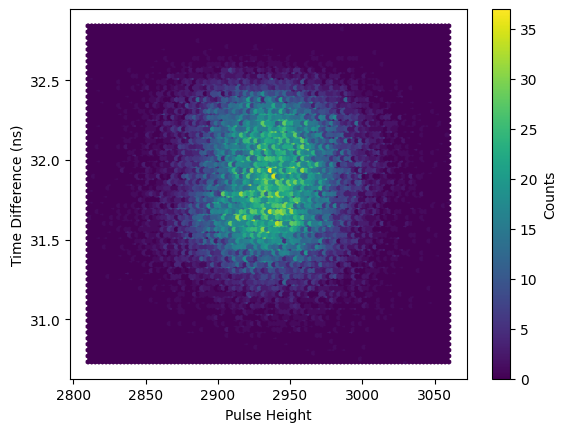

In [31]:
h1 = dfplay['0_max']
h2 = dfplay['0_CDFtime_diff']

fig, ax = plt.subplots()
hb = ax.hexbin(h1, h2, gridsize=100, cmap='viridis')
ax.set_xlabel('Pulse Height')
ax.set_ylabel('Time Difference (ns)')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Counts')

plt.show()


In [ ]:
import awkward as ak
import uproot
import os
import numpy as np

def createRootFromPandasDF(df, output_file, tree_name='tree'):
    try:
        print("Converting to Awkward Array")
        
        # Create a dictionary to hold the data
        data_dict = {}
        
        for col in df.columns:
            if df[col].dtype == 'object' and isinstance(df[col].iloc[0], (list, np.ndarray)):
                # For columns containing arrays, convert to a 2D numpy array
                max_length = df[col].str.len().max()
                data_dict[col] = ak.Array(df[col].apply(lambda x: np.pad(x, (0, max_length - len(x)), 'constant', constant_values=np.nan)).tolist())
            else:
                # For other columns, convert normally
                data_dict[col] = ak.Array(df[col].values)

        ak_array = ak.Array(data_dict)

        print(f"Saving to ROOT file: {output_file}")

        # Remove the existing file if it exists
        if os.path.exists(output_file):
            os.remove(output_file)
            print(f"Removed existing file: {output_file}")

        # Create the new ROOT file
        with uproot.recreate(output_file) as f:
            f[tree_name] = ak_array

        print(f"DataFrame saved as a ROOT TTree '{tree_name}' in '{output_file}'")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

# Usage
output_file = "27.root"
createRootFromPandasDF(dfplay, output_file, tree_name='tree')

Converting to Awkward Array
An error occurred: Awkward Array does not support arrays with object dtypes.


In [ ]:
for col in dfplay.columns:
    if type(dfplay[col].iloc[0]) == np.ndarray:
        print(col)

len(dfplay['0_cfd'][0])


0_cfd
0_values
1_cfd
1_values
99_cfd
99_values


1024

dfplay.to_csv('27.csv', index=False)

import ROOT
import csv
import numpy as np
import math

def get_column_types(csv_file):
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        first_row = next(reader)
        types = []
        for value in first_row:
            try:
                float(value)
                types.append('float')
            except ValueError:
                types.append('string')
    return header, types

def csv_to_root(csv_file, root_file):
    # Get column names and types
    column_names, column_types = get_column_types(csv_file)

    # Create ROOT file and tree
    root_output = ROOT.TFile(root_file, 'RECREATE')
    tree = ROOT.TTree('mytree', 'Tree from CSV')

    # Create dictionary to hold branch variables
    branches = {}
    for name, type in zip(column_names, column_types):
        if type == 'float':
            branches[name] = np.array([0], dtype=np.float32)
            tree.Branch(name, branches[name], f'{name}/F')
        else:
            branches[name] = ROOT.std.string()
            tree.Branch(name, branches[name])

    # Read CSV and fill the tree
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            for name, value in row.items():
                if column_types[column_names.index(name)] == 'float':
                    if value.strip() == '':
                        branches[name][0] = float('nan')  # or use 0.0 if you prefer
                    else:
                        try:
                            branches[name][0] = float(value)
                        except ValueError:
                            print(f"Warning: Could not convert '{value}' to float in column '{name}'. Using NaN.")
                            branches[name][0] = float('nan')
                else:
                    branches[name].replace(0, ROOT.std.string.npos, value)
            tree.Fill()

    # Write and close the ROOT file
    root_output.Write()
    root_output.Close()

# Usage
csv_to_root('27.csv', 'output.root')